In [1]:
from hmcmetad import hMCMetaD
import numpy as np
import hoomd
from hoomd import md
import gsd.hoomd

In [2]:
import math
import itertools
import time
import coxeter

In [3]:
# Define shape
name = 'bipyramid'
n = 6 # n: number of center pyramid vertices
aspect = 1.12 # apsect: aspect ratio of the dipyramid
vertices = []

base_ngon = np.array(
    [[np.cos(i * 2 * np.pi / n),
    np.sin(i * 2 * np.pi / n), 0] for i in np.linspace(0, int(n-1), int(n))])
ngon = coxeter.shapes.ConvexPolygon(base_ngon)

vertices.extend(base_ngon)

h = ngon.circumcircle.radius * aspect
vertices.extend(np.array([[0, 0, h]]))
vertices.extend(np.array([[0, 0, -h]]))
shape = coxeter.shapes.ConvexPolyhedron(vertices)
shape.volume = 1.
verts = shape.vertices.tolist()
mass = 1
inertia = np.diagonal(shape.inertia_tensor) * mass
r_in = shape.maximal_centered_bounded_sphere.radius
r_circum = shape.minimal_centered_bounding_sphere.radius

In [4]:
# Define simulation parameters
final_pf = 0.36
run_params = dict(N_random = 2e5, N_compress = 2e5, N_eq = 1e6)

fname = f'{name}_pf_{final_pf}'

In [5]:
# Create initial configuration at a much lower density

N_particles = 50
K = math.ceil(N_particles**(1 / 3))
spacing = 2.5 # > particle size
L = K * spacing
x = np.linspace(-L / 2,
                L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = position[0 : N_particles]
orientation = [[1, 0, 0, 0]] * N_particles

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.mass = [mass] * N_particles
frame.particles.moment_inertia = [inertia] * N_particles
frame.particles.position = position
frame.particles.orientation = orientation
frame.particles.types = [name]
frame.configuration.box = [L, L, L, 0, 0, 0]

with gsd.hoomd.open('./data/init_config.gsd', mode='w') as f:
    f.append(frame)

In [6]:
# Set up simulation

cpu = hoomd.device.CPU(notice_level=2)
seed = np.random.randint(np.random.randint(10000))
sim = hoomd.Simulation(device=cpu, seed=seed)
sim.create_state_from_gsd(filename='./data/init_config.gsd')

kT = 1.0
dt = 0.0005
integrator = md.Integrator(dt=dt)
nl = md.nlist.Cell(buffer=0.4)

# Define ALJ parameters
sigma = 2.0 * r_in
r_cut = 2.0*r_circum + 0.15*sigma
alj = md.pair.aniso.ALJ(nl)
alj.r_cut[(name, name)] = r_cut
alj.params[(name, name)] = dict(epsilon=0.1,
                                sigma_i=sigma,
                                sigma_j=sigma,
                                alpha=0)

alj.shape[name] = dict(vertices=verts,
                        faces=shape.faces, rounding_radii=0)

integrator.forces.append(alj)

bussi = md.methods.thermostats.Bussi(kT=kT, tau=100*dt)
nvt = md.methods.ConstantVolume(filter=hoomd.filter.All(), thermostat=bussi)

integrator.methods.append(nvt)
integrator.integrate_rotational_dof = True
sim.operations.integrator = integrator

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
thermodynamic_properties = md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)
sim.run(0)

In [7]:
# First, randomize the system for N_random steps
# Create an operation for compressing the system to target density over N_compress steps

box_variant = hoomd.variant.box.InverseVolumeRamp(initial_box=sim.state.box,
                                                 final_volume=sim.state.N_particles * shape.volume / final_pf,
                                                 t_start=int(run_params['N_random']),
                                                 t_ramp=int(run_params['N_compress']))
box_resize = hoomd.update.BoxResize(trigger=hoomd.trigger.Periodic(100),
                                    filter=hoomd.filter.All(),
                                    box=box_variant)

sim.operations.updaters.append(box_resize)

In [8]:
# Set up loggers for simulation output

dump_period = 5e3
log_period = 5e3

table_logger = hoomd.logging.Logger(categories=['scalar', 'string'])
table_logger.add(sim, quantities=['timestep', 'tps', 'seed', 'walltime'])
output_file = open(f'./data/output_{fname}.txt', mode='w', newline='\n')
table = hoomd.write.Table(output=output_file,
                            trigger=hoomd.trigger.Periodic(period=int(log_period)),
                            logger=table_logger)
sim.operations.writers.append(table)

logger = hoomd.logging.Logger()
logger.add(alj, quantities=['type_shapes', 'energy'])
logger.add(integrator, quantities=['linear_momentum'])
logger.add(thermodynamic_properties, quantities=['kinetic_temperature', 'pressure',
                                                    'kinetic_energy', 'translational_kinetic_energy',
                                                    'rotational_kinetic_energy', 'potential_energy',
                                                    'volume'])
traj_writer = hoomd.write.GSD(filename=f'./data/init_nvt_{fname}.gsd',
                                trigger=hoomd.trigger.Periodic(int(dump_period)),
                                mode='wb',
                                logger=logger,
                                dynamic=['property', 'momentum'])
sim.operations.writers.append(traj_writer)

In [9]:
total_timestep = int(run_params['N_random'] + run_params['N_compress'])
while sim.timestep < total_timestep:
    step_size = int(total_timestep - sim.timestep)
    sim.run(min(1e5, step_size))
    traj_writer.flush()

sim.operations.writers.remove(traj_writer)

80


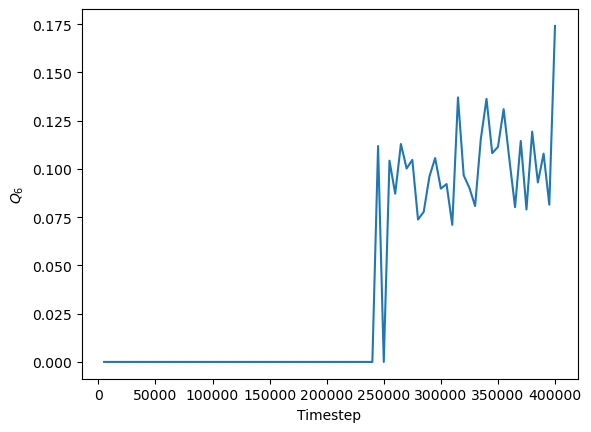

In [10]:
# OPTIONAL
# Plot Q6 to check the system

import matplotlib.pyplot as plt
import gsd.hoomd
from colvar import Colvar

init_traj = gsd.hoomd.open(f'./data/init_nvt_{fname}.gsd')
print(len(init_traj))

timestep = []
q6_arr = []
# linear_momentum = []
mode = 'steinhardt'
colvar_params = dict(r_max=2.0, l=6, average=False, wl=False, weighted=False, wl_normalize=False)
colvar = Colvar(mode=mode, extra_var=colvar_params)

for frame in init_traj:
    timestep.append(frame.configuration.step)
    q6_arr.append(colvar.func(frame))

fig, ax = plt.subplots()
ax.plot(timestep, q6_arr)
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$Q_6$')
plt.show()

In [11]:
########### Turn on WTmetaD ###########

integrator.methods.remove(nvt)
dt = 0.0005
tau = 100*dt
bussi = md.methods.thermostats.Bussi(kT=kT, tau=tau)
nvt = md.methods.ConstantVolume(filter=hoomd.filter.All(), thermostat=bussi)
integrator.methods.append(nvt)
sim.operations.integrator.dt = dt

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
sim.run(0)

mc_stride = 100
metad_stride = mc_stride * 500
init_height = 1.0
sigma = 0.01
gamma = 20

cv_min = 0.0
cv_max = 0.5
bins = 30

mode = 'steinhardt'
colvar_params = dict(r_max=2.0, l=6, average=False, wl=False, weighted=False, wl_normalize=False)

extra_colvar_mode = 'nematic'
extra_colvar_params = dict(director=[0, 0, 1])

hmcmetad_action = hMCMetaD(
    sim=sim,
    colvar_mode=mode,
    colvar_params = colvar_params,
    kT=kT,
    init_height=init_height,
    mc_stride=mc_stride,
    metad_stride=metad_stride,
    sigma=sigma,
    gamma=gamma,
    cv_min=cv_min,
    cv_max=cv_max,
    bins=bins,
    seed=seed,
    bias_mode=True,
    extra_colvar_mode=extra_colvar_mode,
    extra_colvar_params=extra_colvar_params
)

op = hoomd.update.CustomUpdater(action=hmcmetad_action, trigger=1)
sim.operations += op
sim.operations += mcmetad_action.get_writer('./data/WTMetaD_log.hdf5')

In [12]:
dump_period = metad_stride
traj_writer = hoomd.write.GSD(filename=f'./data/traj_{fname}.gsd',
                                trigger=hoomd.trigger.Periodic(int(dump_period), phase=1),
                                mode='wb',
                                logger=logger,
                                dynamic=['property', 'momentum'])
sim.operations.writers.append(traj_writer)

In [13]:
total_timestep = run_params['N_random'] + run_params['N_compress'] + run_params['N_eq']

while sim.timestep < total_timestep:
    step_size = int(total_timestep - sim.timestep)
    sim.run(min(1e4, step_size))
    mcmetad_action.save_history('./data/WTMetaD_history.txt')

    for writer in sim.operations.writers:
        if hasattr(writer, "flush"):
            writer.flush()

mcmetad_action.save_configuration(config_fn=f'./data/restart_{fname}.gsd', logger=logger)
exit()